In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

In [2]:
sns.set_theme(
  context="paper",
  style="whitegrid",
  palette="colorblind",
  font="Source Sans Pro",
)

In [3]:
%config InlineBackend.figure_format = "retina"

In [50]:
def read_run(file, variant):
  df = pd.read_table(file)
  # Clean up column names
  df.columns = df.columns.str.strip()
  # Drop summary rows
  df = df.iloc[:-3]
  # Only name and line coverage columns
  df = df[["Name", "Cov (L)", "Scope (L)", "CL / SL"]]
  df["Variant"] = variant
  df = df.sort_values("Name", ignore_index=True)
  return df

o0_14_efb_df = read_run("O0-14-mem2reg/git.o-rsb-efb.tsv", "Clang 14, O0 + mem2reg")
o1_12_df = read_run("O1-12/git.o-rsb.tsv", "Clang 12, O1")
o1_13_df = read_run("O1-13/git.o-rsb.tsv", "Clang 13, O1")
o1_14_df = read_run("O1-14/git.o-rsb.tsv", "Clang 14, O1")
o1_14_efb_df = read_run("O1-14/git.o-rsb-efb.tsv", "Clang 14, O1 + KE")
o2_14_df = read_run("O2-14/git.o-rsb.tsv", "Clang 14, O2")

baseline_df = o0_14_efb_df

# Use name values from baseline run (addresses differ)
o1_12_df["Name"] = baseline_df["Name"]
o1_13_df["Name"] = baseline_df["Name"]
o1_14_df["Name"] = baseline_df["Name"]
o1_14_efb_df["Name"] = baseline_df["Name"]
o2_14_df["Name"] = baseline_df["Name"]

distribution_df = pd.concat([
  o0_14_efb_df,
  o1_12_df,
  o1_13_df,
  o1_14_df,
  o1_14_efb_df,
  o2_14_df,
]).reset_index(drop=True)

# TODO: Use some kind of wide operation instead of per row
def normalise(row):
  # Line table may differ between runs, giving different scope line counts
  # Use the largest scope line count from any run to recompute ratio
  all_rows = distribution_df[distribution_df["Name"] == row["Name"]]
  max_scope = all_rows["Scope (L)"].max()
  row["Max Scope (L)"] = max_scope
  row["CL / MSL"] = row["Cov (L)"] / row["Max Scope (L)"]
  # Normalise values to baseline
  base_row = baseline_df[baseline_df["Name"] == row["Name"]]
  row["CL / BCL"] = row["Cov (L)"] / base_row["Cov (L)"].iat[0]
  return row

distribution_df = distribution_df.apply(normalise, axis=1)

# distribution_df[distribution_df["Name"].str.contains("list_cmds   ,sep")]
# distribution_df.sort_values("CL / BCL", ascending=True)

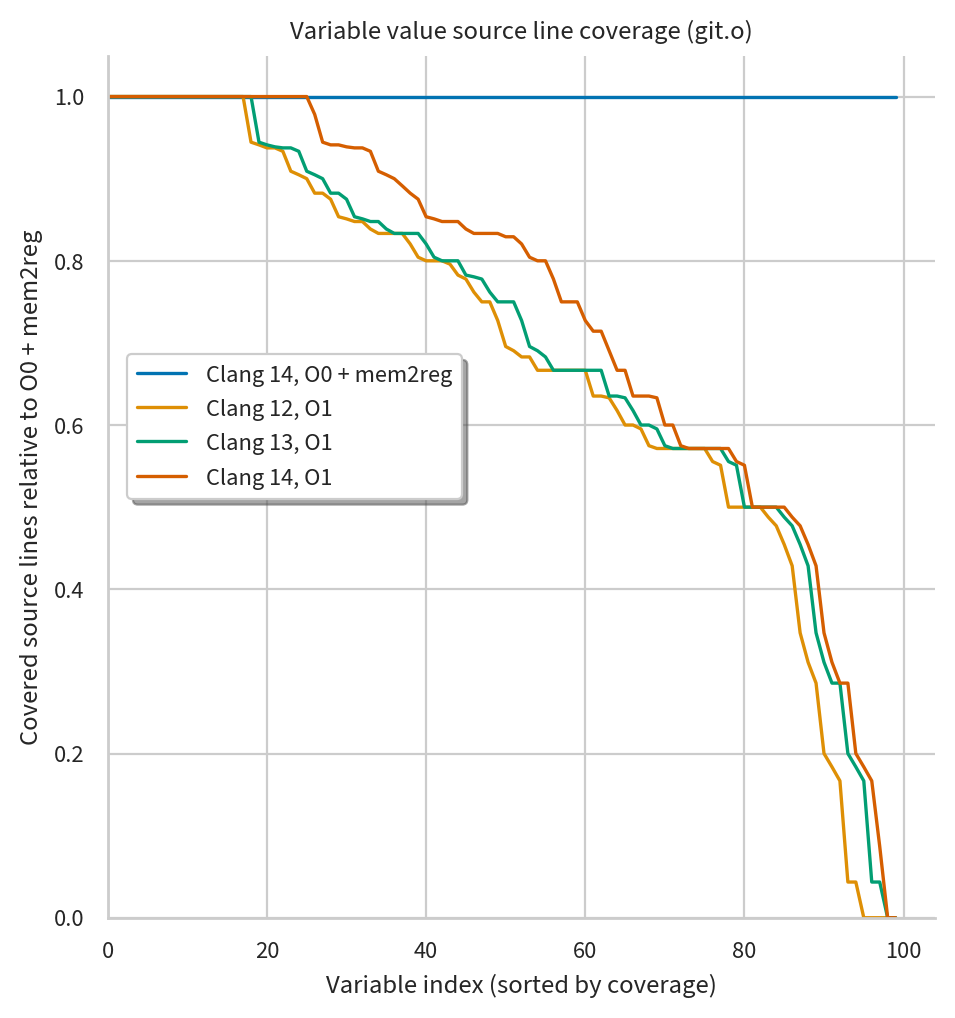

In [5]:
df = distribution_df.copy()
df["Order"] = df.sort_values(by="CL / BCL", ascending=False).groupby("Variant").cumcount()
df = df[df["Variant"].str.contains("O[01]") & ~(df["Variant"].str.contains("DE"))]
g = sns.relplot(
  df,
  x="Order",
  y="CL / BCL",
  hue="Variant",
  kind="line",
)
sns.move_legend(
  g,
  "center left",
  bbox_to_anchor=(0.125, 0.60),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Variable index (sorted by coverage)",
  xbound=(0, None),
  ylabel="Covered source lines relative to O0 + mem2reg",
  ybound=(0, None),
)

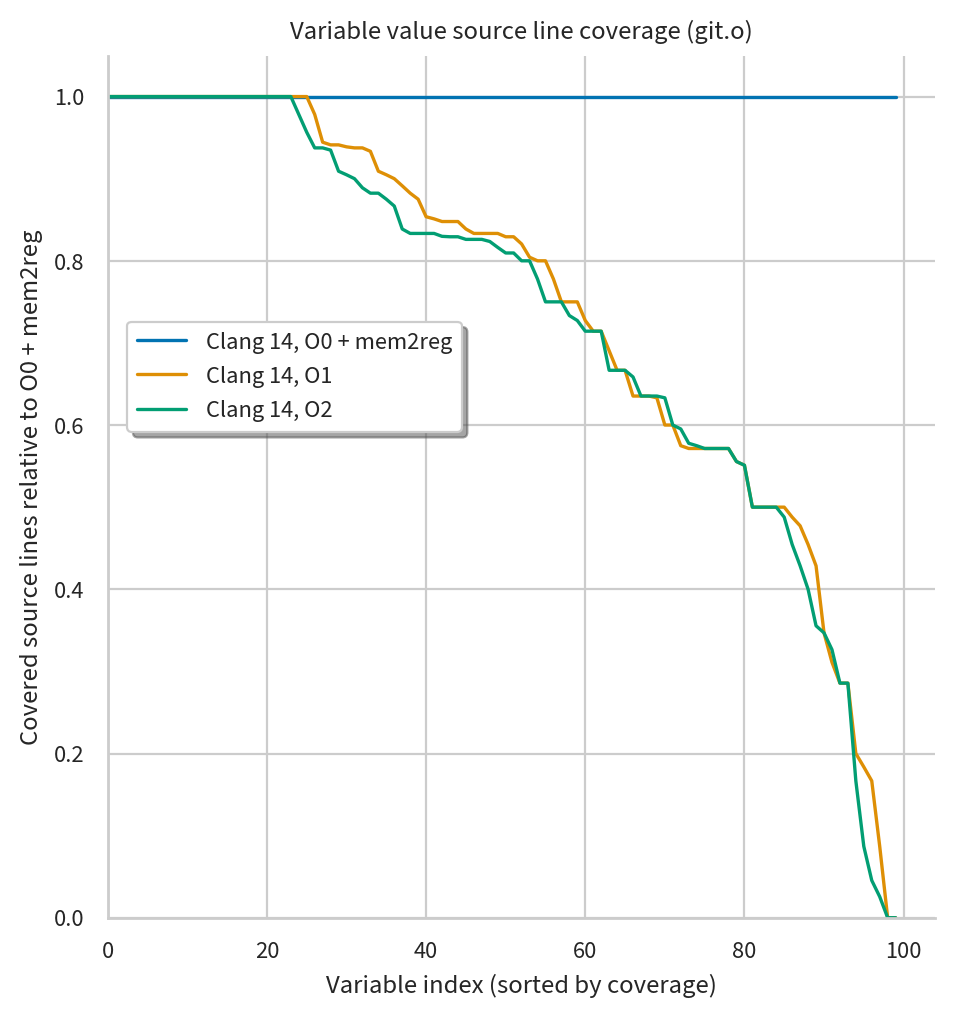

In [6]:
df = distribution_df.copy()
df["Order"] = df.sort_values(by="CL / BCL", ascending=False).groupby("Variant").cumcount()
df = df[df["Variant"].str.contains("Clang 14") & ~(df["Variant"].str.contains("DE"))]
g = sns.relplot(
  df,
  x="Order",
  y="CL / BCL",
  hue="Variant",
  kind="line",
)
sns.move_legend(
  g,
  "center left",
  bbox_to_anchor=(0.125, 0.65),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Variable index (sorted by coverage)",
  xbound=(0, None),
  ylabel="Covered source lines relative to O0 + mem2reg",
  ybound=(0, None),
)

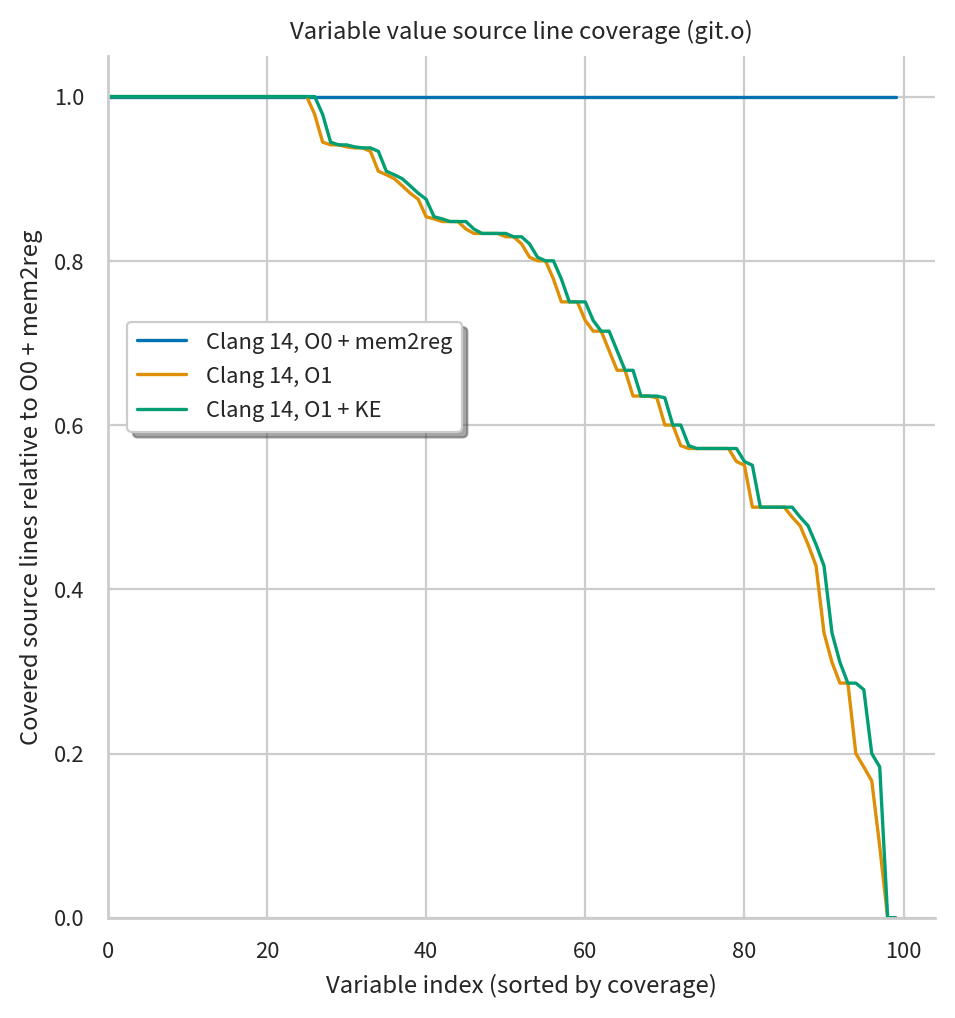

In [51]:
df = distribution_df.copy()
df["Order"] = df.sort_values(by="CL / BCL", ascending=False).groupby("Variant").cumcount()
df = df[df["Variant"].str.contains("Clang 14, O[01]")]
g = sns.relplot(
  df,
  x="Order",
  y="CL / BCL",
  hue="Variant",
  kind="line",
)
sns.move_legend(
  g,
  "center left",
  bbox_to_anchor=(0.125, 0.65),
  frameon=True,
  shadow=True,
  title=None,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Variable index (sorted by coverage)",
  xbound=(0, None),
  ylabel="Covered source lines relative to O0 + mem2reg",
  ybound=(0, None),
)

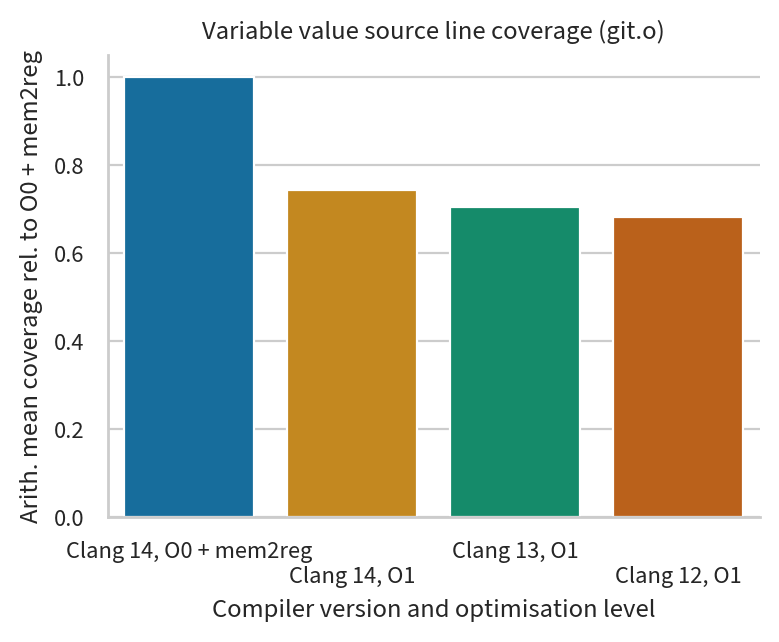

In [7]:
df = distribution_df.copy()
df = df.groupby("Variant")["CL / BCL"].mean().reset_index()
df = df.sort_values(by="CL / BCL", ascending=False).reset_index()
df = df[df["Variant"].str.contains("O[01]") & ~(df["Variant"].str.contains("DE"))]
g = sns.catplot(
  df,
  x="Variant",
  y="CL / BCL",
  kind="bar",
  height=3.0,
  aspect=4 / 3,
)
g.set(
  title="Variable value source line coverage (git.o)",
  xlabel="Compiler version and optimisation level",
  xticklabels=["\n"*(i%2) + l for i,l in enumerate(df["Variant"])],
  ylabel="Arith. mean coverage rel. to O0 + mem2reg",
)